In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


Goals:

- Create periodic test data
- Understand basic usage of LSTM
- Good forecast with LSTM

## Create periodic data for testing

In [2]:
# x range
x_max = 20000

# Angular velocities and amplitudes
omega1 = 2*np.pi / 25
Y1_max = 0

omega2 = 2*np.pi / 500
Y2_max = 10

omega3 = 2*np.pi / 5000
Y3_max = 10

# Gaussian noise variance
var_noise = 0.1

In [3]:
x = np.linspace(0, x_max, x_max)

In [4]:
# Generate component data
Y1 = Y1_max* np.sin(omega1*x)
Y2 = Y2_max* np.sin(omega2*x)
Y3 = Y3_max* np.sin(omega3*x)
Y_noise = np.random.normal(0,var_noise,x_max)

In [5]:
# Add components
Y = pd.DataFrame(Y1 + Y2 + Y3 + Y_noise)

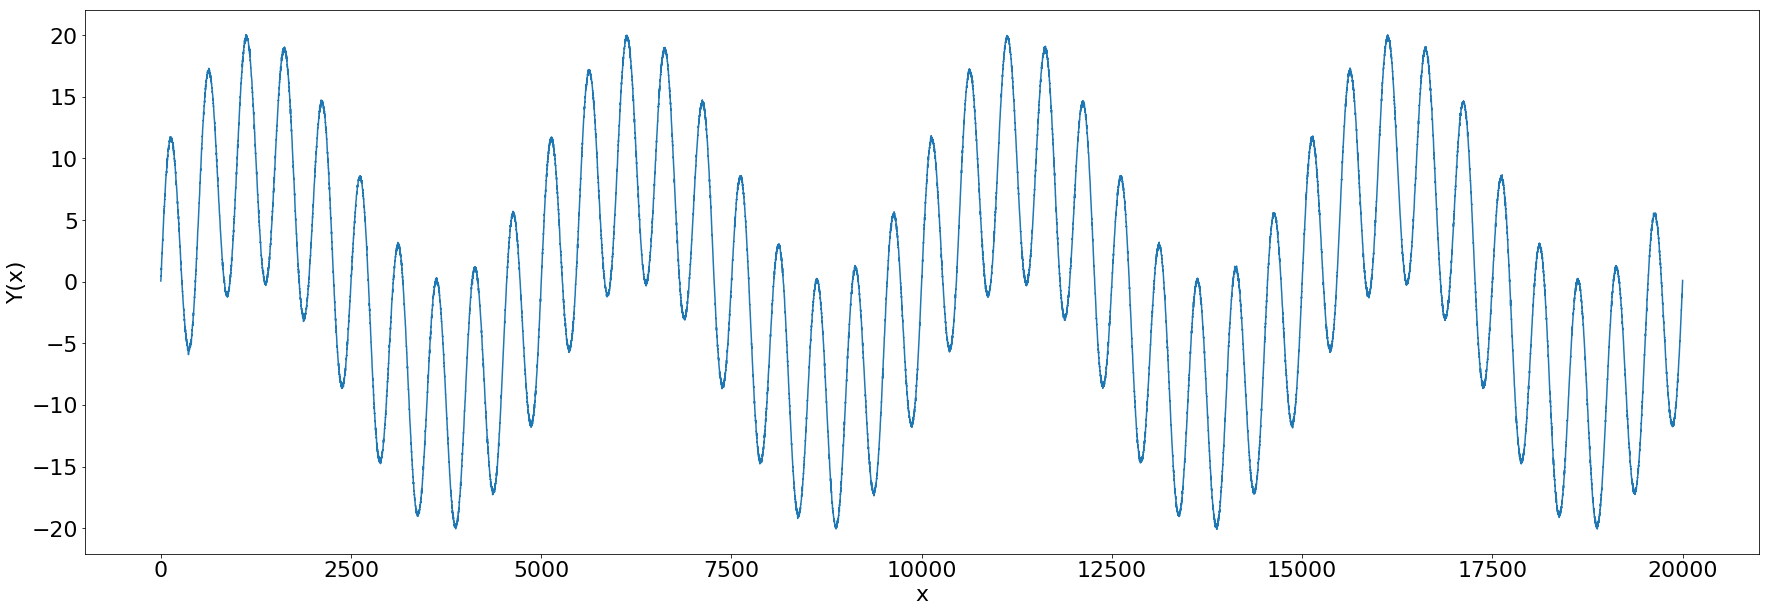

In [6]:
# Plot the data
plt.rcParams["figure.figsize"] = [30,10]
matplotlib.rcParams.update({'font.size': 22})
plt.plot(x, Y)
plt.xlabel('x')
plt.ylabel('Y(x)')
plt.axis('tight')
plt.show()

## Build an LSTM to predict the next point given a sequence of points

In [7]:
# Inspired by:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

In [8]:
# Transform data to interval 0...1
scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaled = pd.DataFrame(scaler.fit_transform((Y)))

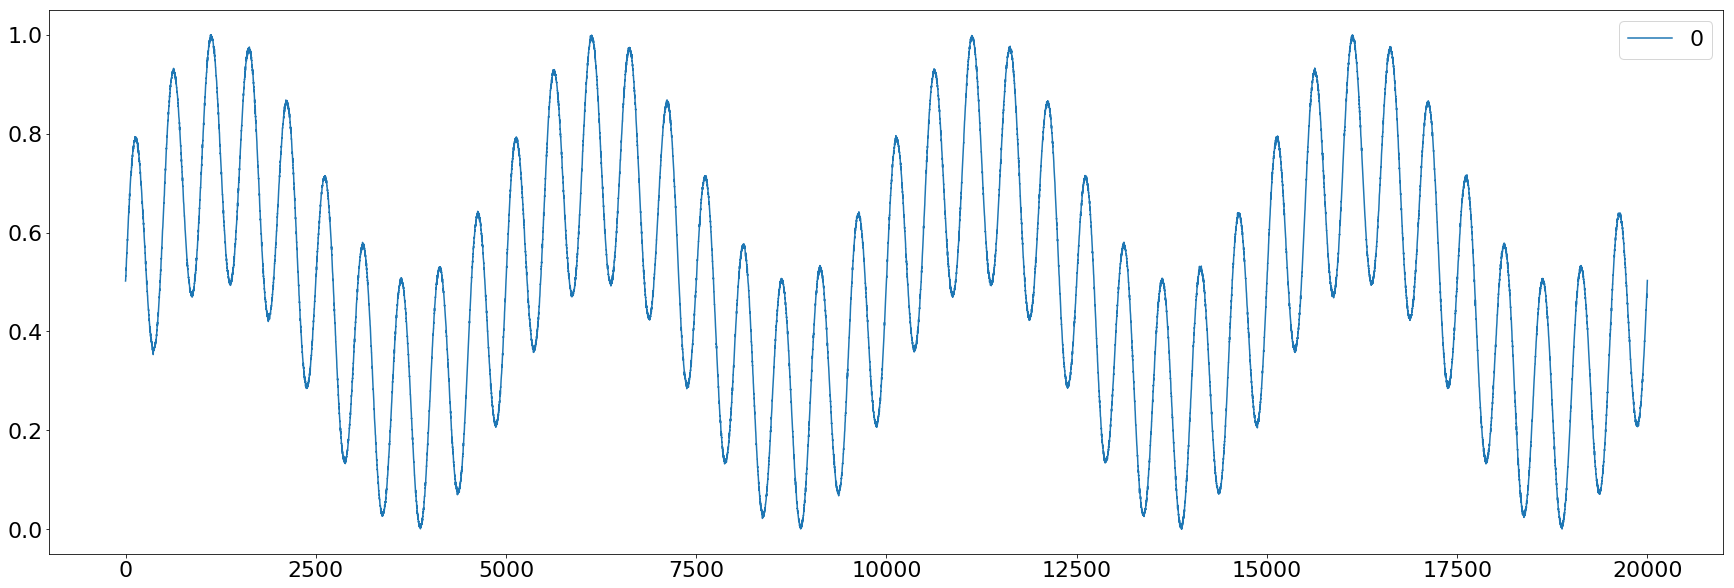

In [9]:
Y_scaled.plot()

In [10]:
# Split test and train
split_fraction = 0.8

Y_train = Y_scaled[0:int(split_fraction*len(Y_scaled))]
Y_test = Y_scaled[int(split_fraction*len(Y_scaled)):]

In [11]:
def transform_data_for_LSTM(Y, delta_T, T = 1):
    """ Converts times series data Y to a representation for LSTM
    with window size delta_T and forecast distance T

    Args:   Y (numpy array): (n_timepoints x 1) Vector with rows corresponding to time points (to do: allow matrix)
    
            delta_T (unsigned int): Window size of data to consider
            
            T (unsigned int): Time to look into future
    
    Return: X_lstm_in: numpy array ((n_timepoints - delta_T - T + 1) x delta_T)
            Y_lstm_out: : numpy array ((n_timepoints - delta_T - T + 1) x 1)
    """    

    X_lstm_in, Y_lstm_out = [], []
    
    for i in range(len(Y)-delta_T - T + 1):
        
        a = Y[i:(i + delta_T), 0]
        X_lstm_in.append(a)
        Y_lstm_out.append(Y[i + delta_T + T - 1, 0])
        
    return np.array(X_lstm_in), np.array(Y_lstm_out)

In [12]:
T = 1
delta_T = 1000

In [13]:
X_lstm_in_train, Y_lstm_out_train = transform_data_for_LSTM(Y_train.values, delta_T = delta_T, T = T)
X_lstm_in_test, Y_lstm_out_test = transform_data_for_LSTM(Y_test.values, delta_T = delta_T, T = T)

In [14]:
X_lstm_in_train.shape

(15000, 1000)

## Create the LSTM

In [15]:
batch_size = 500

In [16]:
X_lstm_in_train_ = np.reshape(X_lstm_in_train, (X_lstm_in_train.shape[0], 1, X_lstm_in_train.shape[1]))
X_lstm_in_test_ = np.reshape(X_lstm_in_test, (X_lstm_in_test.shape[0], 1, X_lstm_in_test.shape[1]))

In [17]:
X_lstm_in_train_.shape

(15000, 1, 1000)

In [18]:
model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, 1, delta_T), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
loss = []
for i in range(15):
    history = model.fit(X_lstm_in_train_, Y_lstm_out_train, epochs=1, batch_size = batch_size, verbose=2, shuffle=False)
    loss.append(history.history['loss'])
    
    model.reset_states()

Epoch 1/1
 - 1s - loss: 0.4380
Epoch 1/1
 - 1s - loss: 0.0538
Epoch 1/1
 - 1s - loss: 0.0261
Epoch 1/1
 - 1s - loss: 0.0138
Epoch 1/1
 - 1s - loss: 0.0064
Epoch 1/1
 - 1s - loss: 0.0030
Epoch 1/1
 - 1s - loss: 0.0036
Epoch 1/1
 - 1s - loss: 0.0024
Epoch 1/1
 - 1s - loss: 0.0022
Epoch 1/1
 - 1s - loss: 0.0029
Epoch 1/1
 - 1s - loss: 0.0035
Epoch 1/1
 - 1s - loss: 0.0014
Epoch 1/1
 - 1s - loss: 0.0022
Epoch 1/1
 - 1s - loss: 0.0018
Epoch 1/1
 - 1s - loss: 0.0013


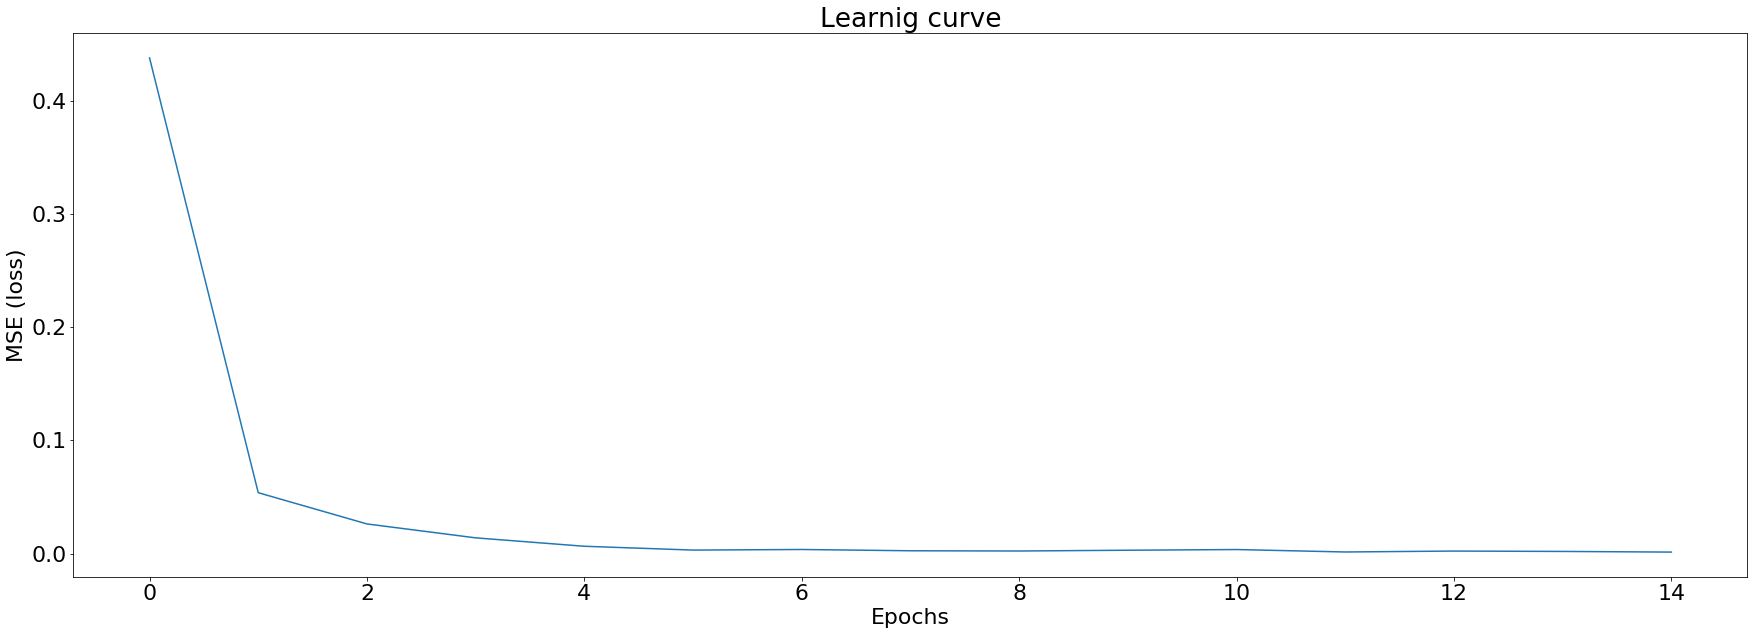

In [20]:
plt.plot(loss)
plt.title('Learnig curve')
plt.ylabel('MSE (loss)')
plt.xlabel('Epochs')
plt.show()

In [21]:
Y_train_predict = model.predict(X_lstm_in_train_, batch_size = batch_size)
Y_test_predict = model.predict(X_lstm_in_test_, batch_size = batch_size)

Retransform data to original scale

In [22]:
Y_train_predict = scaler.inverse_transform(Y_train_predict)
Y_train_ = scaler.inverse_transform(Y_train)

Y_test_predict = scaler.inverse_transform(Y_test_predict)
Y_test_ = scaler.inverse_transform(Y_test)

Print the RMSE error (0 = best)

In [23]:
train_score = math.sqrt(mean_squared_error(Y_train_[0:Y_train_predict.shape[0]], Y_train_predict[:,0]))
print('Train score: %.2f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(Y_test_[0:Y_test_predict.shape[0]], Y_test_predict[:,0]))
print('Test score: %.2f RMSE' % (test_score))

Train score: 8.36 RMSE
Test score: 7.70 RMSE


That is very high, considering that our data just oscillates between -10 and 10. At least no overfitting.

Compare prediction on test to the true values

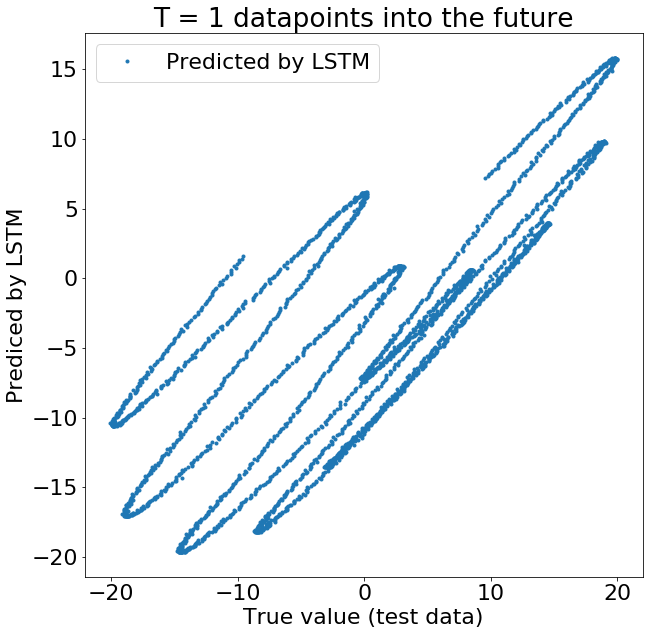

In [24]:
# Plot result
plt.rcParams["figure.figsize"] = [10,10]
matplotlib.rcParams.update({'font.size': 22})
plt.plot(Y_test_[0:Y_test_predict.shape[0]], Y_test_predict[:,0], ".", label = "Predicted by LSTM")
plt.xlabel("True value (test data)")
plt.ylabel("Prediced by LSTM")
str_title = "T = %d datapoints into the future" % (T)
plt.title(str_title)
plt.axis('tight')
plt.legend()

Looks cool, although maybe not the best prediction in the world :-)